In [7]:
import tensorflow as tf

import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Conv2DTranspose
from keras.layers import Dropout, Flatten, Activation, UpSampling2D, Reshape, concatenate
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K

import glob
import shutil

import cv2 
from cv2 import resize, imread, imwrite

import h5py

### Data preprocessing

Upload all data into images and masks.

In [8]:
from cv2 import imread
img_data_path = sorted(glob.glob('/notebooks/b.irina/AxSegmenta/Data/Images/*'))
masks_data_path = sorted(glob.glob('/notebooks/b.irina/AxSegmenta/Data/Masks/*'))

In [9]:
len(img_data_path)

171

In [10]:
images = np.zeros((len(img_data_path),2048,2048))
for i, file in enumerate(img_data_path):
    img = imread(file, 0) #read in grayscale
    images[i] = img

In [11]:
masks = np.zeros((len(masks_data_path),2048,2048))
for i, file in enumerate(masks_data_path):
    mask = imread(file, 0) #read in grayscale
    masks[i] = mask

Let's look up a few image and mask examples:

In [12]:
def draw_examples(images, masks):
  
    indexes = np.random.randint(images.shape[0], size=6)
    print(indexes)
    fig = plt.figure(figsize=(20, 10))
    position = 1
    for i, index in enumerate(indexes): 
        plt.subplot(3, 4, position)
        plt.title('Histology image ' + str(i))
        plt.imshow(images[index],cmap='gray')
        
        plt.subplot(3,4,position+1)
        plt.title('Manual mask ' + str(i))
        plt.imshow(masks[index],cmap='gray')
        position+=2
        
    plt.tight_layout()
    plt.show()

[101 139 148  66 108  62]


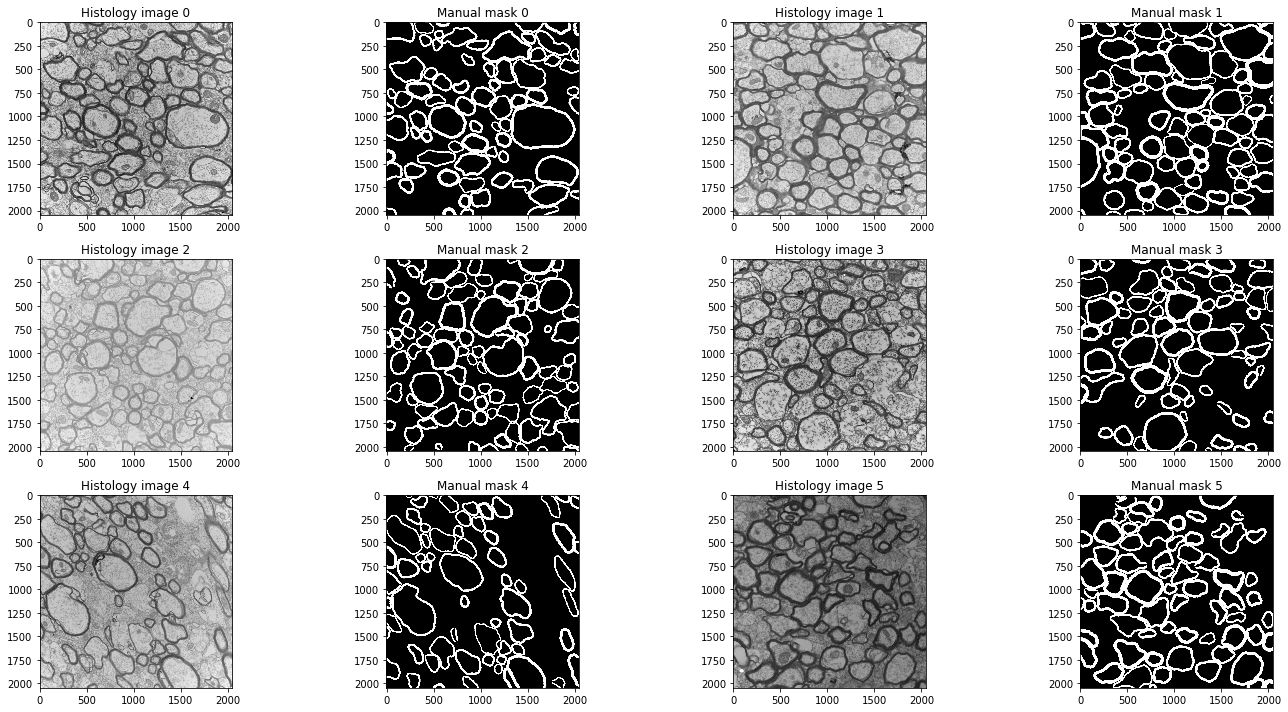

In [13]:
draw_examples(images, masks)

Then we randomly crop 224x224 patches, from each image we crop 100 patches

In [15]:
patch_width = 224
patch_height = 224
patches_num = 100
num_examples = len(images)
width, height = images[0].shape
img_patches = np.zeros((patches_num * num_examples, patch_width, patch_height))
masks_patches = np.zeros((patches_num * num_examples, patch_width, patch_height))

for example in range(num_examples):
    img = images[example]
    mask = masks[example]
    for i in range(patches_num):
        rand_x = np.random.randint(0, width - patch_width +1)
        rand_y = np.random.randint(0, height - patch_height +1)
        top = rand_y
        left = rand_x
        bottom = top + patch_height
        right = left + patch_width
        img_patch = img[top:bottom, left:right]
        mask_patch = mask[top:bottom, left:right]
        imwrite('../Data/Images_patch_224/control_raw_%d.png' %(example*i),img_patch)
        imwrite('../Data/Masks_patch_224/control_raw_%d.png' %(example*i), 
                mask_patch*255)
        img_patches[example*patches_num + i] = img_patch
        masks_patches[example*patches_num + i] = mask_patch


In [20]:
def draw_examples(images, masks):
  
    indexes = np.random.randint(images.shape[0], size=6)
    #print(indexes)
    fig = plt.figure(figsize=(20, 10))
    print("Patched images")
    position = 1
    for i, index in enumerate(indexes): 
        plt.subplot(3, 4, position)
        plt.title('Patched image ' + str(i))
        plt.imshow(images[index],cmap='gray')
        
        plt.subplot(3,4,position+1)
        plt.title('Manual mask ' + str(i))
        plt.imshow(masks[index],cmap='gray')
        position+=2
        
    plt.tight_layout()
    plt.show()

Patched images


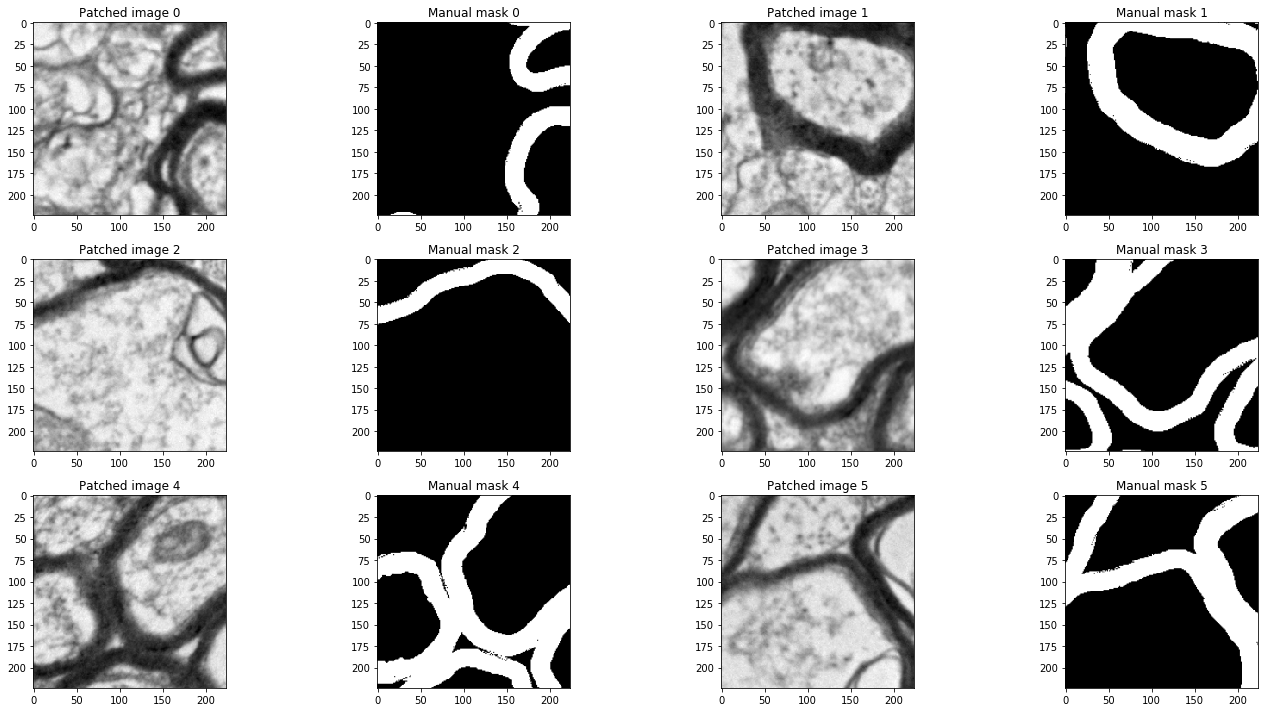

In [24]:
draw_examples(img_patches, masks_patches)

Then we split the dataset into train, valid and test in ration 70:20:10

In [41]:
def data_split(imgs_path, masks_path, basic_path, train_ratio = 0.7, valid_ratio = 0.2, test_ratio = 0.1):
    images_filenames = glob.glob(imgs_path+'*.png')
    masks_filenames = glob.glob(masks_path+'*.png')
    paired_filenames = sorted(list(zip(images_filenames, masks_filenames)))
    # shuffle
    random.shuffle(paired_filenames)
    images_filenames, masks_filenames = zip(*paired_filenames)
    # split data
    total_examples = len(images_filenames)
    train_index = int(total_examples * train_ratio)
    valid_index = train_index + int(total_examples * valid_ratio)

    images_filenames_train, masks_filenames_train = images_filenames[:train_index],\
                                                    masks_filenames[:train_index]

    images_filenames_valid, masks_filenames_valid = images_filenames[train_index:valid_index],\
                                                    masks_filenames[train_index:valid_index]

    images_filenames_test, masks_filenames_test = images_filenames[valid_index:],\
                                                  masks_filenames[valid_index:]

    # save data
    for filename in images_filenames_train:
        shutil.copy2(filename, basic_path+'train/images/')
    for filename in masks_filenames_train:
        shutil.copy2(filename, basic_path+'train/masks/')

    for filename in images_filenames_valid:
        shutil.copy2(filename, basic_path+'valid/images/')
    for filename in masks_filenames_valid:
        shutil.copy2(filename, basic_path+'valid/masks/')

    for filename in images_filenames_test:
        shutil.copy2(filename, basic_path+'test/images/')
    for filename in masks_filenames_test:
        shutil.copy2(filename, basic_path+'test/masks/')

In [47]:
imgs_path = '/notebooks/b.irina/AxSegmenta/Data/Images_patch_224/'
masks_path = '/notebooks/b.irina/AxSegmenta/Data/Masks_patch_224/'
basic_path = '/notebooks/b.irina/AxSegmenta/Data/'
data_split(imgs_path, masks_path)

In [49]:
files_train = glob.glob(basic_path+'train/images/*')
files_test = glob.glob(basic_path+'test/images/*')
files_valid = glob.glob(basic_path+'valid/images/*')
print('There are {} images in train dataset, {} images in validation dataset, {} images in test dataset'.format(len(files_train),len(files_valid),len(files_test)))

There are 4173 images in train dataset, 1192 images in validation dataset, 597 images in test dataset


## Testing ImageDataGenerator, the model and loss function

In [1]:
from data_generator import *

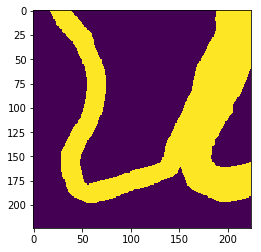

In [12]:
for img, msk in batch_generator(batch_size = 3):
    plt.imshow(img[0].reshape(224,224))
    plt.imshow(msk[0].reshape(224,224))
    break

In [24]:
img_filenames = glob.glob('/notebooks/b.irina/AxSegmenta/Data/train/images/control_raw_*')
mask_filenames = glob.glob('/notebooks/b.irina/AxSegmenta/Data/train/images/control_raw_*')
paired_filenames = list(zip(img_filenames, mask_filenames))
np.random.shuffle(paired_filenames)
img_filenames, mask_filenames = zip(*paired_filenames)

mask_filenames

('/notebooks/b.irina/AxSegmenta/Data/train/images/control_raw_7848.png',
 '/notebooks/b.irina/AxSegmenta/Data/train/images/control_raw_5504.png',
 '/notebooks/b.irina/AxSegmenta/Data/train/images/control_raw_240.png',
 '/notebooks/b.irina/AxSegmenta/Data/train/images/control_raw_8140.png',
 '/notebooks/b.irina/AxSegmenta/Data/train/images/control_raw_11398.png',
 '/notebooks/b.irina/AxSegmenta/Data/train/images/control_raw_7345.png',
 '/notebooks/b.irina/AxSegmenta/Data/train/images/control_raw_3403.png',
 '/notebooks/b.irina/AxSegmenta/Data/train/images/control_raw_5886.png',
 '/notebooks/b.irina/AxSegmenta/Data/train/images/control_raw_10048.png',
 '/notebooks/b.irina/AxSegmenta/Data/train/images/control_raw_9898.png',
 '/notebooks/b.irina/AxSegmenta/Data/train/images/control_raw_3144.png',
 '/notebooks/b.irina/AxSegmenta/Data/train/images/control_raw_1177.png',
 '/notebooks/b.irina/AxSegmenta/Data/train/images/control_raw_5810.png',
 '/notebooks/b.irina/AxSegmenta/Data/train/images/

## Training

Look at the model:

In [30]:
!pip install pydot graphviz

You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
from model import *
unet_model = unet_224()

Using TensorFlow backend.


In [2]:
from keras.utils import plot_model
plot_model(unet_model, show_shapes = True, show_layer_names = True, to_file='model.png')

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

Training with no pretrained weights, no aug

In [2]:
from model import *
from train import *

train_unet()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 224, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 224, 224, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

Epoch 1/400
 - 98s - loss: -5.2044e-01 - dice_coef: 0.5204 - val_loss: -5.2297e-01 - val_dice_coef: 0.5230
Epoch 2/400
 - 86s - loss: -5.4596e-01 - dice_coef: 0.5460 - val_loss: -5.3217e-01 - val_dice_coef: 0.5322
Epoch 3/400
 - 85s - loss: -5.7863e-01 - dice_coef: 0.5786 - val_loss: -5.8006e-01 - val_dice_coef: 0.5801
Epoch 4/400
 - 80s - loss: -6.0151e-01 - dice_coef: 0.6015 - val_loss: -4.7809e-01 - val_dice_coef: 0.4781
Epoch 5/400
 - 85s - loss: -6.2206e-01 - dice_coef: 0.6221 - val_loss: -6.2280e-01 - val_dice_coef: 0.6228
Epoch 6/400
 - 85s - loss: -6.4342e-01 - dice_coef: 0.6434 - val_loss: -6.4327e-01 - val_dice_coef: 0.6433
Epoch 7/400
 - 61s - loss: -6.6915e-01 - dice_coef: 0.6691 - val_loss: -6.4736e-01 - val_dice_coef: 0.6474
Epoch 8/400
 - 44s - loss: -6.7710e-01 - dice_coef: 0.6771 - val_loss: -6.6754e-01 - val_dice_coef: 0.6675
Epoch 9/400
 - 44s - loss: -6.9415e-01 - dice_coef: 0.6941 - val_loss: -6.6877e-01 - val_dice_coef: 0.6688
Epoch 10/400
 - 48s - loss: -7.1074e-

Epoch 77/400
 - 76s - loss: -8.9924e-01 - dice_coef: 0.8992 - val_loss: -8.7352e-01 - val_dice_coef: 0.8735
Epoch 78/400
 - 75s - loss: -8.9691e-01 - dice_coef: 0.8969 - val_loss: -8.7921e-01 - val_dice_coef: 0.8792
Epoch 79/400
 - 74s - loss: -8.9778e-01 - dice_coef: 0.8978 - val_loss: -8.8484e-01 - val_dice_coef: 0.8848
Epoch 80/400
 - 75s - loss: -9.0144e-01 - dice_coef: 0.9014 - val_loss: -8.8425e-01 - val_dice_coef: 0.8842
Epoch 81/400
 - 74s - loss: -9.0425e-01 - dice_coef: 0.9043 - val_loss: -8.8337e-01 - val_dice_coef: 0.8834
Epoch 82/400
 - 73s - loss: -8.9942e-01 - dice_coef: 0.8994 - val_loss: -8.8013e-01 - val_dice_coef: 0.8801
Epoch 83/400
 - 72s - loss: -9.0243e-01 - dice_coef: 0.9024 - val_loss: -8.7309e-01 - val_dice_coef: 0.8731
Epoch 84/400
 - 72s - loss: -8.9273e-01 - dice_coef: 0.8927 - val_loss: -8.8287e-01 - val_dice_coef: 0.8829
Epoch 85/400
 - 76s - loss: -9.0380e-01 - dice_coef: 0.9038 - val_loss: -8.8430e-01 - val_dice_coef: 0.8843
Epoch 86/400
 - 76s - loss: 

Training synthetic data

In [1]:
%env CUDA_VISIBLE_DEVICES = 0
import sys
sys.path.insert(0, '/notebooks/b.irina/AxSegmenta/ZF_UNET_224_Pretrained_Model-master')
from train_infinite_generator import *

train_unet()

env: CUDA_VISIBLE_DEVICES=0


Using TensorFlow backend.


Start training...
Epoch 1/400
 - 51s - loss: -1.9970e-01 - dice_coef: 0.1997 - val_loss: -1.4131e-01 - val_dice_coef: 0.1413
Epoch 2/400
 - 44s - loss: -2.1802e-01 - dice_coef: 0.2180 - val_loss: -1.5358e-01 - val_dice_coef: 0.1536
Epoch 3/400
 - 44s - loss: -2.3870e-01 - dice_coef: 0.2387 - val_loss: -1.8635e-01 - val_dice_coef: 0.1863
Epoch 4/400
 - 47s - loss: -2.5665e-01 - dice_coef: 0.2567 - val_loss: -2.5094e-01 - val_dice_coef: 0.2509
Epoch 5/400
 - 46s - loss: -2.7349e-01 - dice_coef: 0.2735 - val_loss: -2.6787e-01 - val_dice_coef: 0.2679
Epoch 6/400
 - 46s - loss: -2.9573e-01 - dice_coef: 0.2957 - val_loss: -3.0596e-01 - val_dice_coef: 0.3060
Epoch 7/400
 - 41s - loss: -3.0878e-01 - dice_coef: 0.3088 - val_loss: -3.0114e-01 - val_dice_coef: 0.3011
Epoch 8/400
 - 47s - loss: -3.3818e-01 - dice_coef: 0.3382 - val_loss: -3.7251e-01 - val_dice_coef: 0.3725
Epoch 9/400
 - 41s - loss: -3.7001e-01 - dice_coef: 0.3700 - val_loss: -3.1818e-01 - val_dice_coef: 0.3182
Epoch 10/400
 - 46s

Epoch 77/400
 - 40s - loss: -9.6980e-01 - dice_coef: 0.9698 - val_loss: -9.6028e-01 - val_dice_coef: 0.9603
Epoch 78/400
 - 41s - loss: -9.7030e-01 - dice_coef: 0.9703 - val_loss: -9.5200e-01 - val_dice_coef: 0.9520
Epoch 79/400
 - 41s - loss: -9.7226e-01 - dice_coef: 0.9723 - val_loss: -9.5132e-01 - val_dice_coef: 0.9513
Epoch 80/400
 - 41s - loss: -9.6336e-01 - dice_coef: 0.9634 - val_loss: -9.6555e-01 - val_dice_coef: 0.9655
Epoch 81/400
 - 39s - loss: -9.6819e-01 - dice_coef: 0.9682 - val_loss: -9.6694e-01 - val_dice_coef: 0.9669
Epoch 82/400
 - 46s - loss: -9.6912e-01 - dice_coef: 0.9691 - val_loss: -9.7472e-01 - val_dice_coef: 0.9747
Epoch 83/400
 - 41s - loss: -9.7334e-01 - dice_coef: 0.9733 - val_loss: -9.5727e-01 - val_dice_coef: 0.9573
Epoch 84/400
 - 46s - loss: -9.7167e-01 - dice_coef: 0.9717 - val_loss: -9.7532e-01 - val_dice_coef: 0.9753
Epoch 85/400
 - 46s - loss: -9.7497e-01 - dice_coef: 0.9750 - val_loss: -9.8247e-01 - val_dice_coef: 0.9825
Epoch 86/400
 - 41s - loss: 

Training with pretrained weights (trained on synthetic data)

In [1]:
from model import *
from train import *

%env CUDA_VISIBLE_DEVICES = 0
train_unet()

Using TensorFlow backend.


env: CUDA_VISIBLE_DEVICES=0
Loading weights from pretrained on synth data
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 224, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 224, 224, 32) 0           batch_normalization_1[0][0]      
___________________________________

Epoch 1/400
 - 48s - loss: -6.2618e-01 - dice_coef: 0.6262 - val_loss: -7.5809e-01 - val_dice_coef: 0.7581
Epoch 2/400
 - 43s - loss: -8.0012e-01 - dice_coef: 0.8001 - val_loss: -8.0501e-01 - val_dice_coef: 0.8050
Epoch 3/400
 - 39s - loss: -8.2532e-01 - dice_coef: 0.8253 - val_loss: -6.5869e-01 - val_dice_coef: 0.6587
Epoch 4/400
 - 39s - loss: -8.3179e-01 - dice_coef: 0.8318 - val_loss: -6.4606e-01 - val_dice_coef: 0.6461
Epoch 5/400
 - 39s - loss: -8.3949e-01 - dice_coef: 0.8395 - val_loss: -3.5885e-01 - val_dice_coef: 0.3589
Epoch 6/400
 - 39s - loss: -8.4463e-01 - dice_coef: 0.8446 - val_loss: -6.6972e-01 - val_dice_coef: 0.6697
Epoch 7/400
 - 44s - loss: -8.5444e-01 - dice_coef: 0.8544 - val_loss: -8.3506e-01 - val_dice_coef: 0.8351
Epoch 8/400
 - 38s - loss: -8.5286e-01 - dice_coef: 0.8529 - val_loss: -8.2862e-01 - val_dice_coef: 0.8286
Epoch 9/400
 - 39s - loss: -8.4873e-01 - dice_coef: 0.8487 - val_loss: -7.1510e-01 - val_dice_coef: 0.7151
Epoch 10/400
 - 39s - loss: -8.4759e-

Epoch 77/400
 - 39s - loss: -9.0161e-01 - dice_coef: 0.9016 - val_loss: -8.7427e-01 - val_dice_coef: 0.8743
Epoch 78/400
 - 39s - loss: -8.9871e-01 - dice_coef: 0.8987 - val_loss: -8.7650e-01 - val_dice_coef: 0.8765
Epoch 79/400
 - 39s - loss: -9.0207e-01 - dice_coef: 0.9021 - val_loss: -8.7504e-01 - val_dice_coef: 0.8750
Epoch 80/400
 - 39s - loss: -9.0123e-01 - dice_coef: 0.9012 - val_loss: -8.7955e-01 - val_dice_coef: 0.8796
Epoch 81/400
 - 39s - loss: -9.0236e-01 - dice_coef: 0.9024 - val_loss: -8.7767e-01 - val_dice_coef: 0.8777
Epoch 82/400
 - 43s - loss: -9.0415e-01 - dice_coef: 0.9042 - val_loss: -8.8525e-01 - val_dice_coef: 0.8853
Epoch 83/400
 - 38s - loss: -9.0524e-01 - dice_coef: 0.9052 - val_loss: -8.6970e-01 - val_dice_coef: 0.8697
Epoch 84/400
 - 39s - loss: -9.0350e-01 - dice_coef: 0.9035 - val_loss: -8.8210e-01 - val_dice_coef: 0.8821
Epoch 85/400
 - 39s - loss: -9.0799e-01 - dice_coef: 0.9080 - val_loss: -8.7929e-01 - val_dice_coef: 0.8793
Epoch 86/400
 - 39s - loss: 

Continiue training

In [1]:
from model import *
from train import *

%env CUDA_VISIBLE_DEVICES = 0
train_unet()

Using TensorFlow backend.


env: CUDA_VISIBLE_DEVICES=0
Loading weights from pretrained model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 224, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 224, 224, 32) 0           batch_normalization_1[0][0]      
___________________________________________

Epoch 1/400
 - 48s - loss: -9.1703e-01 - dice_coef: 0.9170 - val_loss: -8.8292e-01 - val_dice_coef: 0.8829
Epoch 2/400
 - 43s - loss: -9.1522e-01 - dice_coef: 0.9152 - val_loss: -8.8758e-01 - val_dice_coef: 0.8876
Epoch 3/400
 - 39s - loss: -9.1717e-01 - dice_coef: 0.9172 - val_loss: -8.8282e-01 - val_dice_coef: 0.8828
Epoch 4/400
 - 39s - loss: -9.2073e-01 - dice_coef: 0.9207 - val_loss: -8.8050e-01 - val_dice_coef: 0.8805
Epoch 5/400
 - 39s - loss: -9.2129e-01 - dice_coef: 0.9213 - val_loss: -8.7934e-01 - val_dice_coef: 0.8793
Epoch 6/400
 - 39s - loss: -9.2344e-01 - dice_coef: 0.9234 - val_loss: -8.8728e-01 - val_dice_coef: 0.8873
Epoch 7/400
 - 39s - loss: -9.2017e-01 - dice_coef: 0.9202 - val_loss: -8.8487e-01 - val_dice_coef: 0.8849
Epoch 8/400
 - 44s - loss: -9.2183e-01 - dice_coef: 0.9218 - val_loss: -8.8774e-01 - val_dice_coef: 0.8877
Epoch 9/400
 - 38s - loss: -9.2120e-01 - dice_coef: 0.9212 - val_loss: -8.7961e-01 - val_dice_coef: 0.8796
Epoch 10/400
 - 39s - loss: -9.2229e-

Epoch 77/400
 - 39s - loss: -9.5173e-01 - dice_coef: 0.9517 - val_loss: -8.8800e-01 - val_dice_coef: 0.8880
Epoch 78/400
 - 39s - loss: -9.4922e-01 - dice_coef: 0.9492 - val_loss: -8.8111e-01 - val_dice_coef: 0.8811
Epoch 79/400
 - 39s - loss: -9.5031e-01 - dice_coef: 0.9503 - val_loss: -8.8995e-01 - val_dice_coef: 0.8899
Epoch 80/400
 - 39s - loss: -9.5150e-01 - dice_coef: 0.9515 - val_loss: -8.8696e-01 - val_dice_coef: 0.8870
Epoch 81/400
 - 39s - loss: -9.4937e-01 - dice_coef: 0.9494 - val_loss: -8.8488e-01 - val_dice_coef: 0.8849
Epoch 82/400
 - 39s - loss: -9.5178e-01 - dice_coef: 0.9518 - val_loss: -8.8667e-01 - val_dice_coef: 0.8867
Epoch 83/400
 - 39s - loss: -9.5166e-01 - dice_coef: 0.9517 - val_loss: -8.8720e-01 - val_dice_coef: 0.8872
Epoch 84/400
 - 39s - loss: -9.5164e-01 - dice_coef: 0.9516 - val_loss: -8.8894e-01 - val_dice_coef: 0.8889
Epoch 85/400
 - 39s - loss: -9.5136e-01 - dice_coef: 0.9514 - val_loss: -8.8745e-01 - val_dice_coef: 0.8875
Epoch 86/400
 - 39s - loss: 

Epoch 153/400
 - 39s - loss: -9.6581e-01 - dice_coef: 0.9658 - val_loss: -8.9019e-01 - val_dice_coef: 0.8902
Epoch 154/400
 - 39s - loss: -9.6556e-01 - dice_coef: 0.9656 - val_loss: -8.8905e-01 - val_dice_coef: 0.8891
Epoch 155/400
 - 39s - loss: -9.6551e-01 - dice_coef: 0.9655 - val_loss: -8.8908e-01 - val_dice_coef: 0.8891
Training is finished (weights unet_224.h5 and log unet_224_train.csv are generated )...
